# Troubleshooting RNN as an embedding net prior to Sequential Neural Posterior Estimation (SNPE)

### Set up model and true parameters (repressilator model from Pusnik _et al.,_ 2019)

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# Define repressilator model
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = np.array([
    246.96291990024542, 246.96291990024542, 246.96291990024542,])

# Establish prior from 0-250
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

### Set up simulator

In [3]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data #We can see that simulated trajectories have a shape of [1000, 6].
          #The 'sbi' package will automatically add a batch size to the trajectories so that tensor shape is [1, 1000, 6]

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  2.3466,   4.8680,   2.3466,   6.7172,   2.3466,   5.7926],
        [  4.4394,  15.6593,   4.4394,  17.3690,   4.4394,  16.5141],
        ...,
        [  0.9443,  34.6693,   1.9822, 357.9927,  21.0713, 746.8439],
        [  1.2064,  35.5436,   1.7790, 337.1067,  21.1389, 759.2465],
        [  1.5425,  37.3237,   1.5972, 317.1701,  21.1992, 770.9217]])

The trajectories for the set of parameters chosen as 'true' oscillate:

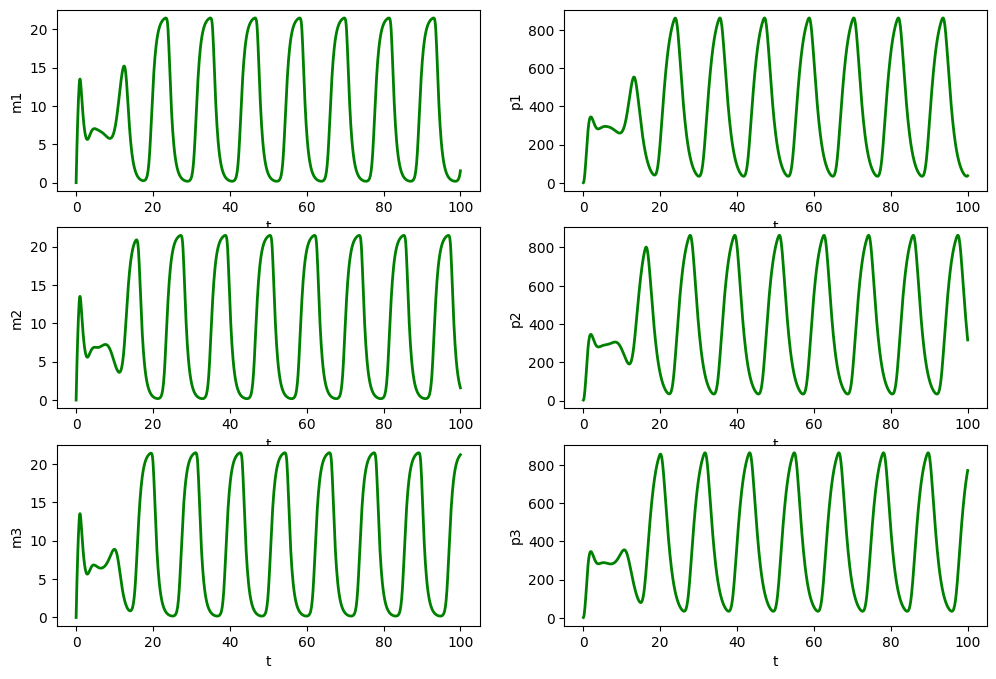

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
for i in range(6):
    axs[i].plot(t, true_data[:, i], linewidth=2, color = "green")
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])

# Neural Posterior Estimation (NPE, non-sequential)

### Instead of using summary statistics to represent trajectories, we want to use an embedding net that represents the 1000x6 tensor into 1x25 embeddings. This network will be trained _alongside_ the density estimator from the (S)NPE algorithm.

In [5]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 1000, 6]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, hn = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:, -1, :])     # It is outputting the last hidden state (timepoint 1000) for each GRU unit (1 x 100).
                                                    # Then feed into linear layer that outputs (1 x 25). These are taken as a set of 'embeddings'
        return output

# Define RNN
input_size = 6 #We have 6 dimensions
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net = RNN(input_size, hidden_size, output_size)

Manually check that the RNN is doing what we want:

In [6]:
toy_6dim = true_data.unsqueeze(0) #shape [1, 1000, 6]
gru = nn.GRU(input_size, hidden_size, batch_first=False)
linear = nn.Linear(hidden_size, output_size)
h = torch.zeros(1, 1000, 100)
gru_out, hn = gru(toy_6dim, h)
output = linear(gru_out[:,-1, :])
output.shape

torch.Size([1, 25])

### Now carry out toy NPE, only 10 simulations to check that it works:

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

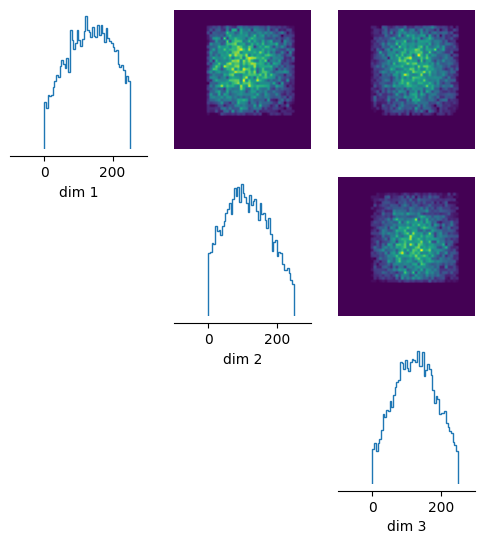

In [7]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Problems/doubts:

- When upscaling this (more simulations), results are not good: we tend to get posteriors centered at the central prior value. We don't know if it's the embedding net or the algorithm itself which is faulty.

- Is it sound to use the above GRU output as an embedding?

- Batch size: currently we have only made it work with a batch size of the entire dataset (1000 for 1000x6 data or 6000 for flattened, 1x6000 data shape). Which batch size to pick? Is it 'sound' to have the batch as the entire trajectory? 
    - Since it it is usually smaller, I have tried to reshape the data but we get a contradicting error (see below). In doing this, we get embeddings for each batch: need a pooling operation such as taking the mean?
    - **The prepare_for_sbi function adds a batch dimension of 1 to the simulations: therefore the simulations always have a [1, dim0, dim1] shape.** We reshape the data in the forward pass.
    - A batch size of 1 only works for flattened input (1D data)...


## Try to reshape data to have a batch size of 100, sequence length of 10 and 6 input dimensions

In [9]:
# The modified embedding net:
class RNNp(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNp, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)    #Batch size is specified by the FIRST shape number of input. 
                                                                        #In this case, I will reshape the input in the forward pass prior to GRU 
                                                                        #Weights are therefore updated after a pass through 10 datapoints (1 second)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        xb = x.view(100, 10, 6) #Batch size of 100, 10 datapoints in each batch, 6 dimensions
        h = torch.zeros(1, 100, self.hidden_size)           # Number of layers, batch_size and number of GRU units
        gru_out, hn = self.gru(xb, h)                       # GRU layer, we don't store the hn (hidden state output)
        multi_d_embeddings = self.linear(gru_out[:, -1, :]) # It is outputting the last hidden state (timepoint 1000) for each GRU unit (100 x 100), after linear the shape is [100 x 25].
        output = torch.mean(multi_d_embeddings, dim = 0)    # A pooling operation of just taking the mean should be valid (?). Output shape is [1 x 25].
        return output

# Define RNN
input_size = 6 #We have 6 dimensions
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net_p = RNNp(input_size, hidden_size, output_size)

Manually check that the RNN is doing what we want:

In [12]:
toy_6dim = true_data.unsqueeze(0) #shape [1, 1000, 6]
toy_reshape = toy_6dim.view(100, 10, 6) #shape [100, 10, 6]
gru = nn.GRU(input_size, hidden_size, batch_first=True)
linear = nn.Linear(hidden_size, output_size)
h = torch.zeros(1, 100, 100)
gru_out, hn = gru(toy_reshape, h)
multi_d_embeddings = linear(gru_out[:,-1, :])
output = torch.mean(multi_d_embeddings, dim = 0).unsqueeze(0) #to have the same dimensionality
output.shape

torch.Size([1, 25])

### Now carry out toy NPE, only 10 simulations to check that it works:

In [13]:
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net_p, hidden_features=10, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: (RuntimeError("shape '[100, 10, 6]' is invalid for input of size 12000"), 'Debug hint: The simulated data x has 2 dimensions.\n            With default settings, sbi cannot deal with multidimensional simulations.\n            Make sure to use an embedding net that reduces the dimensionality, e.g., a\n            CNN in case of images, or change the simulator to return one-dimensional x.\n            ')

Error is that the input size is 12000 instead of 6000: something wrong with hidden states?